Bryan Jay - 260738764

## 1 - Segmentation

##### Q1.1 K-means clustering and Expectation Maximization

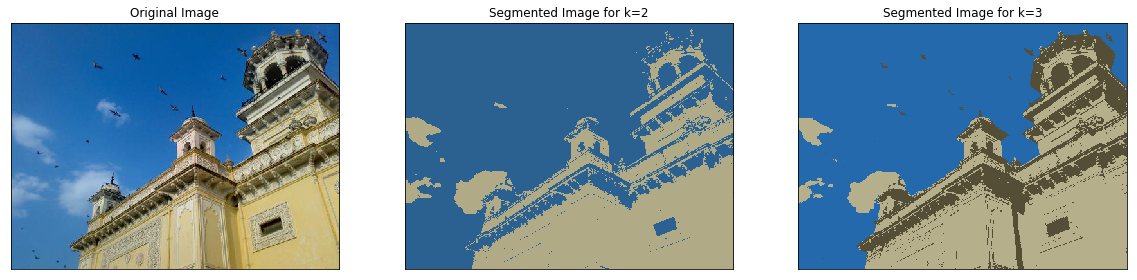

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('./home.jpg')

# convert the colours to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# put the array into a list
img_arr = np.float32(img)
img_arr = img_arr.reshape(-1,3)

# Calculates the Euclidean Distance
def distance(a, b):
    return np.linalg.norm(a-b)

# Calculation to find k means
def findKmeans(img_pts, k):
    # find the random coordinates for (x,y,z) for the clusters
    C_x = np.random.randint(0, np.max(img)-20, size=k)
    C_y = np.random.randint(0, np.max(img)-20, size=k)
    C_z = np.random.randint(0, np.max(img)-20, size=k)
    
    # put the coordinates into an array
    C = np.array(list(zip(C_x, C_y, C_z)), dtype=np.float32)
    distances = np.zeros((k,1))
    
    # loop through the algorithm 10 times
    for x in range(10):
        # intialte the lists for the points in each cluster
        points = [[] for i in range(k)]
        label = [[]]
        # loop through all the points in the image
        for i in range(0, img_pts.shape[0]):
            # gather the distance from each point to the centroid
            for j in range(k):
                distances[j] = distance(img_pts[i], C[j])
            # find which centroid it's closest to
            for j in range(k):
                if distances[j] == np.amin(distances):
                    points[j].append([img_pts[i]])
                    if i==0:
                        label[i] = j
                    else:
                        label = np.hstack((label, j))
        # calculate the new centroid position by taking the mean of the points
        for j in range(k):
            C[j] = np.mean(points[j], axis=0)
    return label, C
    
# call function
label_k2, center_k2 = findKmeans(img_arr, 2)
label_k3, center_k3 = findKmeans(img_arr, 3)

# convert images back into uint8 and reshape segments into the original image
center_k2 = np.uint8(center_k2)
center_k3 = np.uint8(center_k3)

segment_k2 = center_k2[label_k2.flatten()]
segment_k2 = segment_k2.reshape(img.shape)

segment_k3 = center_k3[label_k3.flatten()]
segment_k3 = segment_k3.reshape(img.shape)
            
plt.figure(figsize=(20,20))
plt.subplot(131), plt.imshow(img)
plt.xticks([]), plt.yticks([]), plt.title("Original Image")
plt.subplot(132), plt.imshow(segment_k2)
plt.xticks([]), plt.yticks([]), plt.title("Segmented Image for k=2")
plt.subplot(133), plt.imshow(segment_k3)
plt.xticks([]), plt.yticks([]), plt.title("Segmented Image for k=3")
plt.show()

##### Expectation Maximum
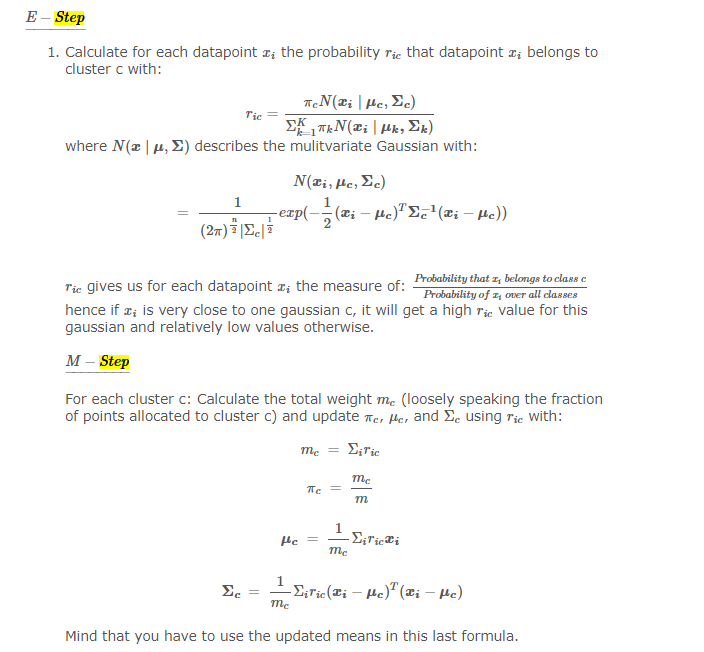
https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php

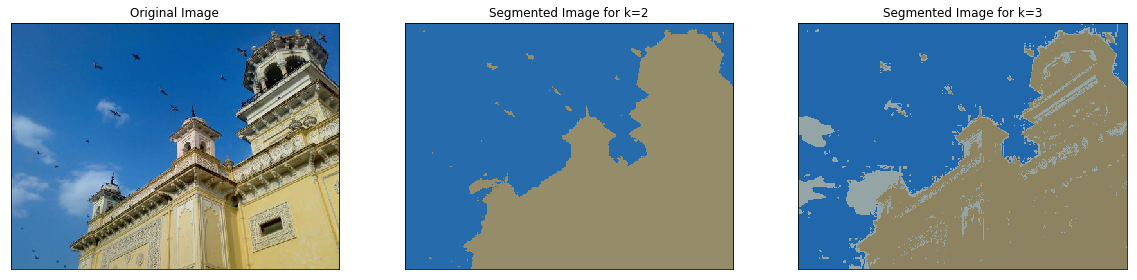

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('./home.jpg')

# convert the colours to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# put the array into a list and put image values into decimals
img_arr = np.float32(img)

# normalize the image
img_arr = img_arr/255

# reshape the image to be flat
img_reshape = np.reshape(img_arr, (img_arr.shape[0]*img_arr.shape[1],-1))

# Calculation to find k means
def findEM(img_pts, k):
    # find the random gaussian mixture model to begin finding probablities
    # ie find the mean std, mixing probability of the kth gaussian
    mean = np.zeros((k,3))
    std = [np.eye(3) for i in range(k)]
    std = np.asarray(std)
    weight = np.ones(k)
    weight *= 1/k
    
    # total pts in the image
    total = img_pts.shape[0]
    
    # get random points for gausianpoints 
    C = np.random.randint(0, img_pts.shape[0]-1, size=k)
    for c in range(k):
        mean[c] = img_pts[C[c]]
    
    # loop through the E and M step algorithms 10 times 
    for x in range(10):
        # E- STEP
        probG = np.zeros((total, k))
        
        # perform the expectation step by determining the probablities of assignment
        for i in range(total):
            for c in range(k):
                # calculate the multivariate Gaussian of each point
                dif_mean = img_pts[i] - mean[c]
                temp = (-1/2)*(np.dot(np.transpose(dif_mean),np.dot(dif_mean, np.linalg.inv(std[c]))))
                mGauss = np.exp(temp)
                mGauss *= weight[c]/(np.sqrt(2*np.pi)*np.sqrt(np.linalg.det(std[c])))
                # store the mGauss into the array for each point in the row 
                probG[i][c] = mGauss
            # at each point calculate the probabiltity by taking the point over the sum of the row
            sum_row = sum(probG[i])
            probG[i] = [probG[i][c]/sum_row for c in range(k)]
        
        # M- STEP
        # initialize new mean, std, weight that are all empty and the same size as the old vlaues
        mean_new = np.zeros((k,3))
        std_new = np.zeros((k,3,3))

        # initilazie the empty values that will be used 
        total_prob = np.zeros((k))

        # calculate the total sum m_c of all the probabilities (also the total weight) per cluster
        for c in range(k):
            for i in range(total):
                total_prob[c] += probG[i][c]

        # calculate new weight m_c/ m
        weight = total_prob/total

        # calculate the new mean 
        for c in range(k):
            for i in range(total):
                mean_new[c] += probG[i][c]*img_pts[i]
            mean_new[c] = mean_new[c]/total_prob[c]

        # calculate the new standard deviation
        for c in range(k):
            for i in range(total):
                dif_mean = (img_pts[i] - mean_new[c])[np.newaxis]
                temp = np.dot(np.transpose(dif_mean), dif_mean)
                std_new[c] += probG[i][c]*temp
            std_new[c] = std_new[c]/total_prob[c]
            
        mean = mean_new 
        std = std_new 
        

    return probG, mean

k_2 = 2
k_3 = 3

# call functions 
label_g2, mean_g2 = findEM(img_reshape, k_2)
label_g3, mean_g3 = findEM(img_reshape, k_3)

# print the output of the EM function
final_2 = img_reshape.copy() 
for i in range(img_reshape.shape[0]):
    # Find the index for the max probability
    max_index = np.argmax(label_g2[i])
    
    # take the mean at the same index to calulate final image
    final_2[i] = mean_g2[max_index]
final_2 = final_2.reshape(img_arr.shape)

final_3 = img_reshape.copy() 
for i in range(img_reshape.shape[0]):
    # Find the index for the max probability
    max_index = np.argmax(label_g3[i])
    
    # take the mean at the same index to calulate final image
    final_3[i] = mean_g3[max_index]
final_3 = final_3.reshape(img_arr.shape)

plt.figure(figsize=(20,20))
plt.subplot(131), plt.imshow(img)
plt.xticks([]), plt.yticks([]), plt.title("Original Image")
plt.subplot(132), plt.imshow(final_2)
plt.xticks([]), plt.yticks([]), plt.title("Segmented Image for k=2")
plt.subplot(133), plt.imshow(final_3)
plt.xticks([]), plt.yticks([]), plt.title("Segmented Image for k=3")
plt.show()

###  K-means and EM Theory question

K-means and EM can give similar results when EM's gaussian clusters have a similar shape to K-means. Since K-means cluster shape are circles or spherical in 3-D then it would require the data to be ideally in circular or spherical clusters. This is due to the fact that the main bennefit of sperical shapes is that it allows to have clusters that are in ellipses or ellipsoids.